In [1]:
import sys
sys.path.append('C:\\Users\\ryand\\git\\CheetahPy')
from cheetahpy import CheetahPy

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

In [3]:
cp = CheetahPy()

In [4]:
def plot_activity_summary(ac):
    fig, axs = plt.subplots(2, 2, figsize=(7,5))
    ac['kph'].plot(kind='hist', bins=40, title='KPH', ax=axs[0][0])
    ac[ac['lat']!=0][['lat','lon']].plot(x='lon',y='lat',title='Map', ax=axs[0][1])
    ac[ac['hr'] > ac['hr'].quantile(.05)]['hr'].plot(kind='hist', bins='fd', title='HR', color='red', ax=axs[1][0])
    ac['watts'].plot(kind='hist', bins='fd', title='Power', color='green', ax=axs[1][1])
    fig.tight_layout()

In [11]:
activ = cp.get_activities("Ryan Duecker"
                         ,start_date="2021/01/01"
                         ,end_date="2023/02/01"
                         ,metadata=['Workout_Code','Sport']
                         ,activity_filenames_only=False)

In [130]:
fns = activ[(activ['Sport'] == 'Bike') & (activ['Workout_Code'] == 'AnE')]['filename'].tolist()

In [133]:
len(fns)

71

54.3


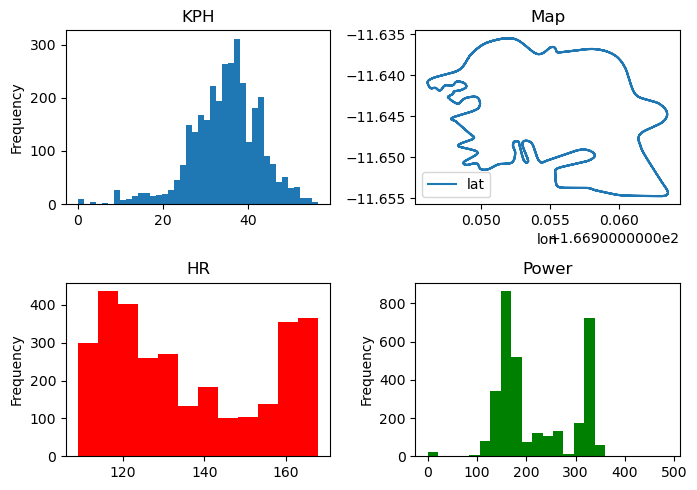

In [31]:
ac = cp.get_activity(athlete="Ryan Duecker"
                    ,activity_filename=fns[-1])
plot_activity_summary(ac)
print(ac['secs'].to_numpy()[-1]/60)

In [32]:
var_Ti = ac['temp'].mean()
var_HRi = ac['hr'].to_numpy()
var_PWRi = ac['watts'].to_numpy()
var_t = ac['secs'].to_numpy()
cons_lag = 15

## Genral Formula
# P_it = a_i + b_i*H_i,t+l + c*t*T_i
X = np.vstack((var_HRi[cons_lag:],(var_t[:-cons_lag] * var_Ti))).T
y = var_PWRi[:-cons_lag]

In [33]:
reg = LinearRegression(fit_intercept=True).fit(X, y)

In [34]:
y_hat = reg.predict(X)
errors = y - y_hat
(errors**2).sum()/errors.shape[0]

1932.020300527965

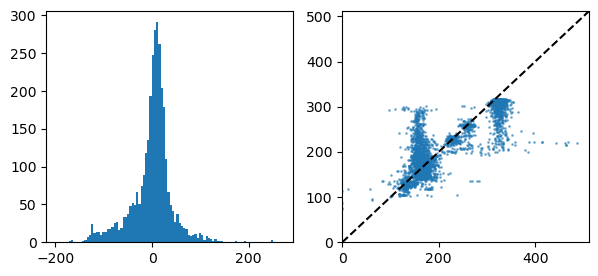

In [35]:
fig, axs = plt.subplots(1,2, figsize=(7,3))
axs[0].hist(errors, label='errors', bins='fd')
axs[1].plot(np.linspace(0,y.max()*1.25,5),np.linspace(0,y.max()*1.25,5), ls='--', color='black')
axs[1].scatter(y, y_hat, label='actual vs. predicted', s=1, alpha=.5)
axs[1].set_xlim(0,y.max()*1.05)
axs[1].set_ylim(0,y.max()*1.05);

In [30]:
[reg.intercept_,reg.coef_]

[-178.4091470596474, array([ 3.35753014e+00, -1.52410150e-03])]

In [36]:
[reg.intercept_,reg.coef_]

[-180.62830612345726, array([ 3.25590798e+00, -1.02131080e-03])]

## Production functions

In [ ]:
activ = cp.get_activities("Ryan Duecker"
                         ,start_date="2021/01/01"
                         ,end_date="2023/02/01"
                         ,metadata=['Workout_Code','Sport']
                         ,activity_filenames_only=False)
fns = activ[activ['Average_Power']]['filename'].tolist()

In [39]:
def extract_activity_data(fn):
    ac = cp.get_activity(athlete="Ryan Duecker"
                    ,activity_filename=fn)
    var_Ti = ac['temp'].mean()
    var_HRi = ac['hr'].to_numpy()
    var_PWRi = ac['watts'].to_numpy()
    var_t = ac['secs'].to_numpy()
    cons_lag = 15

    ## Genral Formula
    # P_it = a_i + b_i*H_i,t+l + c*t*T_i
    X = np.vstack((var_HRi[cons_lag:],(var_t[:-cons_lag] * var_Ti))).T
    y = var_PWRi[:-cons_lag]
    return X, y
    

In [127]:
def make_coef(X,y):
    reg = LinearRegression(fit_intercept=True).fit(X, y)
    a = reg.intercept_
    b,c = reg.coef_
    rmse = np.sqrt(((y - reg.predict(X))**2).mean())
    return a,b,c, rmse

In [135]:
def process_filenames(fns):
    details = {'files':fns
                ,'modeled':[]}
    for fn in fns:
        print(fn)
        X, y = extract_activity_data(fn)
        a,b,c, rmse = make_coef(X,y)
        details['modeled'].append([a,b,c, rmse])
    return details

In [134]:
files_modeled = process_filenames(fns)

In [141]:
import pandas as pd

In [149]:
df = pd.DataFrame(files_modeled['modeled'],files_modeled['files']).reset_index()

In [150]:
df.columns = ['files','a','b','c','rmse']

In [152]:
df.to_csv('modeled_ef.csv')